In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [3]:
TRAIN_PATH = "../datasets/bitcoinheist-ransomware-dataset/BitcoinHeistData.csv"
train_df = pd.read_csv(TRAIN_PATH, header = 0)
train_df = train_df.drop(columns = ['address'])  
print("Done")

Done


In [4]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


A quick galnce reveals it has no missing values.

In [5]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('int64'): 6, dtype('float64'): 2, dtype('O'): 1}


The object type is the label dataset. Hence, there are no categorical columns.

In [6]:
print(train_df['label'].value_counts())

white                          2875284
paduaCryptoWall                  12390
montrealCryptoLocker              9315
princetonCerber                   9223
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        13
montrealAPT                         11
paduaKeRanger                       10
montrealFlyper                       9
montrealXTPLocker                    8
montrealXLockerv5.0                  7
montrealVenusLocker                  7
montrealCryptConsole                 7
montrealEDA2                         6
montrealJigSaw                       4
paduaJigsaw              

In [7]:
for i in range(len(train_df['label'])):
    if not 'white' in train_df['label'][i]:
        train_df['label'][i] = 'ransom'

/tmp/ipykernel_2964806/1241363097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'][i] = 'ransom'


In [8]:
print(train_df['label'].value_counts())

white     2875284
ransom      41413
Name: label, dtype: int64


In [9]:
label_encoder = LabelEncoder()
i = 'label'
train_df[i] = label_encoder.fit_transform(train_df[i])    

In [10]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df['label']
y_test = test_df['label']
X_train = train_df.drop(['label'], axis = 1)
X_test = test_df.drop(['label'], axis = 1)

In [11]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [12]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [13]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [14]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.987009
Error Rate: 0.012990708677615093
Mean Recall: 0.5963903328175051
Balanced Accuracy Score: 0.5963903328175051
Precision: 0.8119124959016347
F-Score: 0.6455635263451532
291670 291670
Selectivity: 0.1943839264100702
G_mean: 0.3404830312454281


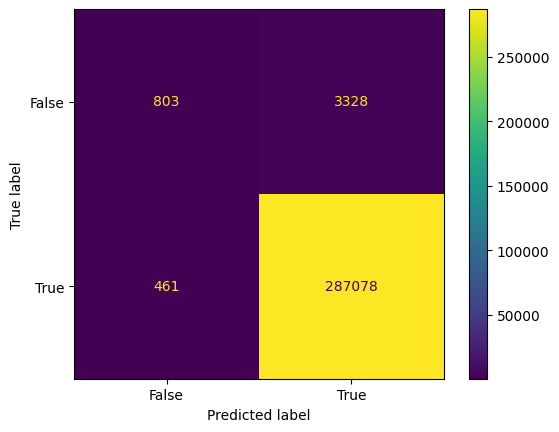

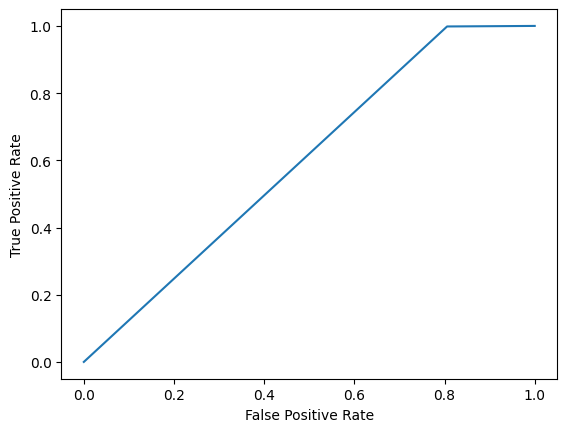

In [15]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({1: 2587745, 0: 2587745})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.838934
Error Rate: 0.16106558782185343
Mean Recall: 0.6515617303242203
Balanced Accuracy Score: 0.6515617303242203
Precision: 0.5157538361645336
F-Score: 0.4932218278130796
291670 291670
Selectivity: 0.4587267005567659
G_mean: 0.5467072002092956


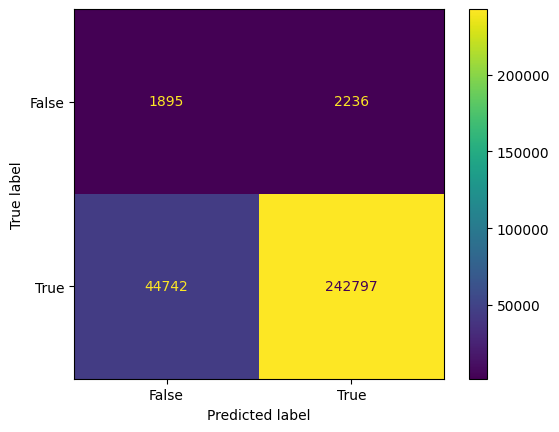

Resampled dataset shape Counter({1: 2587745, 0: 2587745})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.817352
Error Rate: 0.18264819830630508
Mean Recall: 0.6560047246038532
Balanced Accuracy Score: 0.6560047246038532
Precision: 0.5146085715106498
F-Score: 0.4846720166058155
291670 291670
Selectivity: 0.4899540062938756
G_mean: 0.5669322207877838


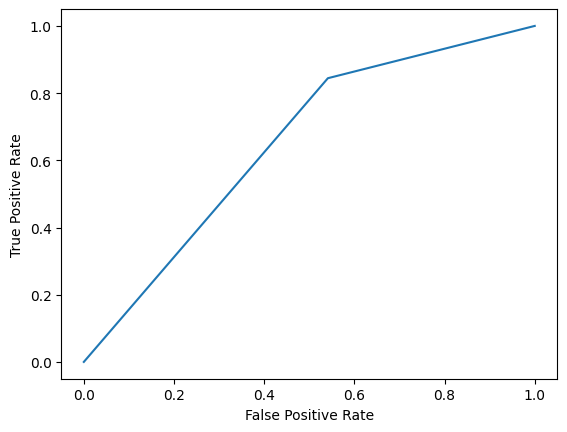

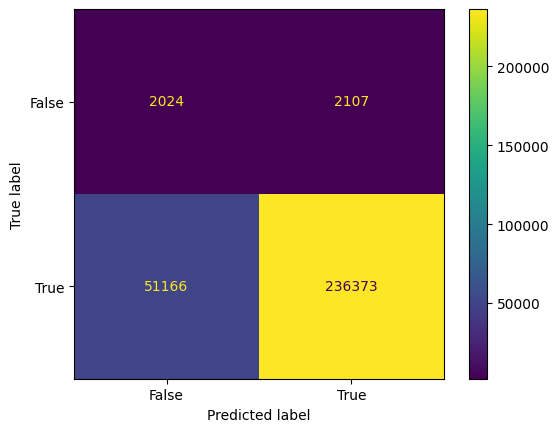

Resampled dataset shape Counter({1: 2587745, 0: 2587745})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.805126
Error Rate: 0.19487434429320805
Mean Recall: 0.6588704118777959
Balanced Accuracy Score: 0.6588704118777959
Precision: 0.5141251754489365
F-Score: 0.4799921223348971
291670 291670
Selectivity: 0.5083514887436456
G_mean: 0.5787380709502499


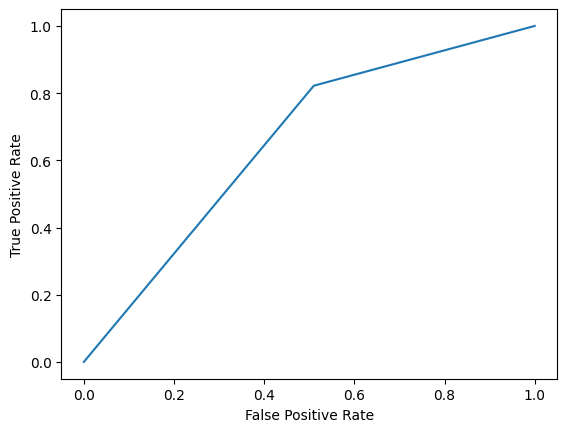

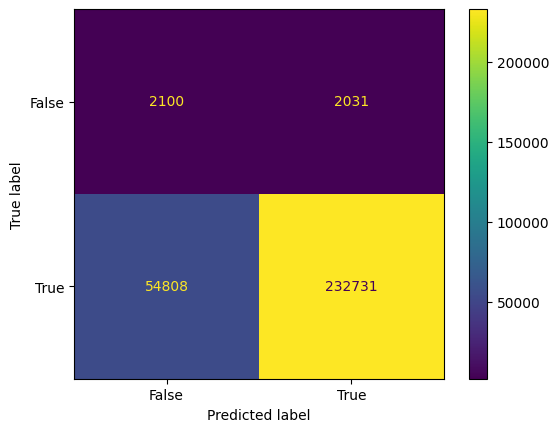

Resampled dataset shape Counter({1: 2587745, 0: 2587745})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.796359
Error Rate: 0.20364110124455725
Mean Recall: 0.6636099409268434
Balanced Accuracy Score: 0.6636099409268434
Precision: 0.5140473210816114
F-Score: 0.47699241536218784
291670 291670
Selectivity: 0.5269910433309126
G_mean: 0.5913683244254824


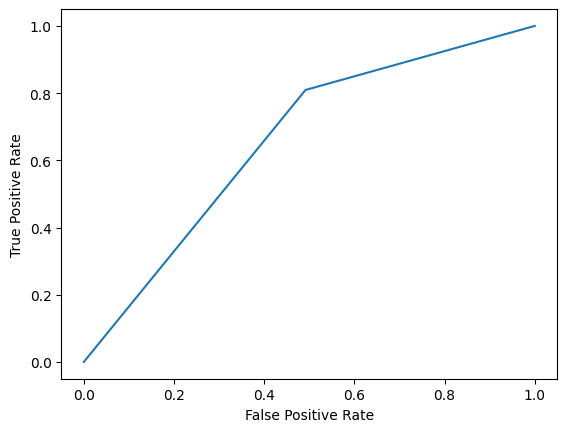

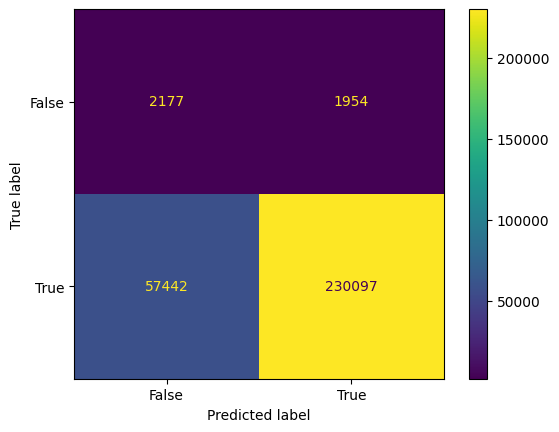

Resampled dataset shape Counter({1: 2587745, 0: 2587745})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.799801
Error Rate: 0.20019885487023004
Mean Recall: 0.6753767536876765
Balanced Accuracy Score: 0.6753767536876765
Precision: 0.5152169280369102
F-Score: 0.4798377521984341
291670 291670
Selectivity: 0.5473251028806584
G_mean: 0.6079890222654621


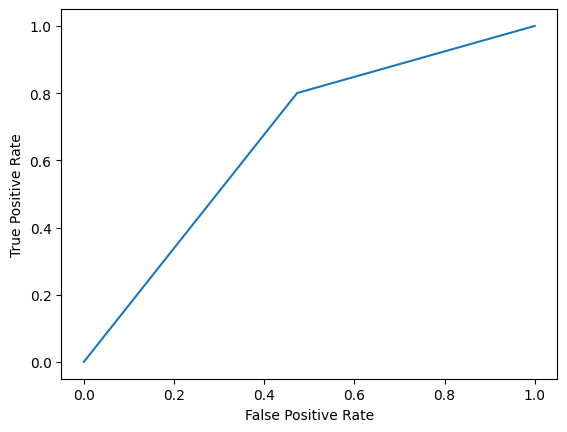

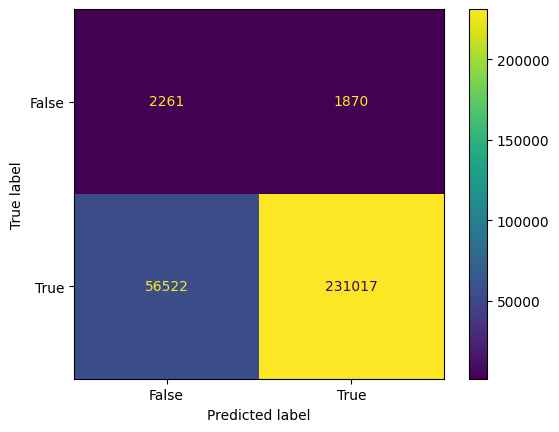

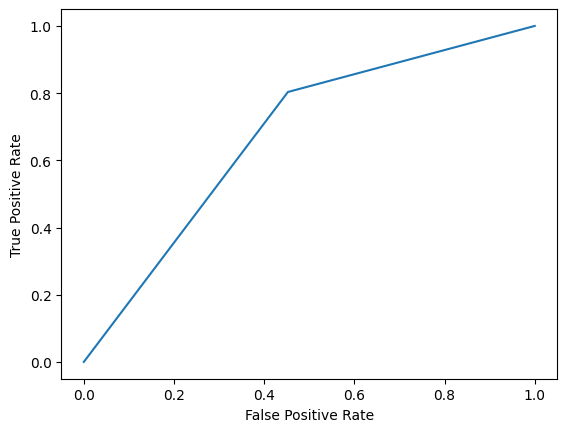

In [16]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.930408
Error Rate: 0.06959234751602839
Mean Recall: 0.6645522281414765
Balanced Accuracy Score: 0.6645522281414765
Precision: 0.5370097863413903
F-Score: 0.5505123179462106
291670 291670
Selectivity: 0.39094650205761317
G_mean: 0.5097100833086424


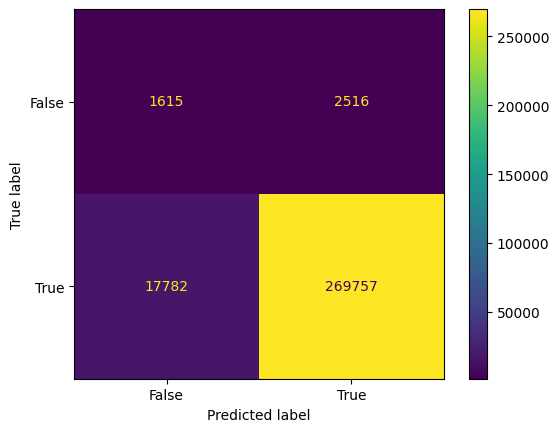

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.894871
Error Rate: 0.10512908423903722
Mean Recall: 0.6680020774869108
Balanced Accuracy Score: 0.6680020774869108
Precision: 0.5253297788213607
F-Score: 0.5244823642365746
291670 291670
Selectivity: 0.43451948680706853
G_mean: 0.5387577562278506


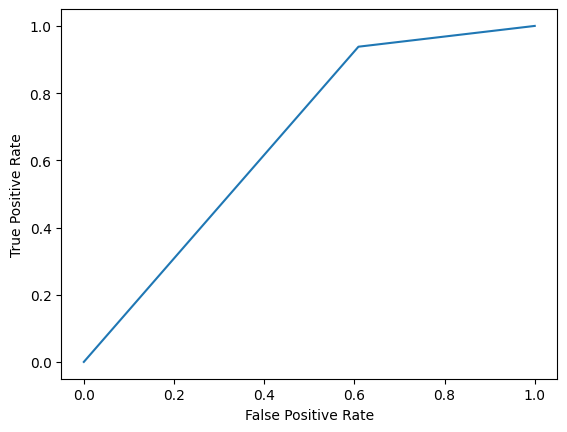

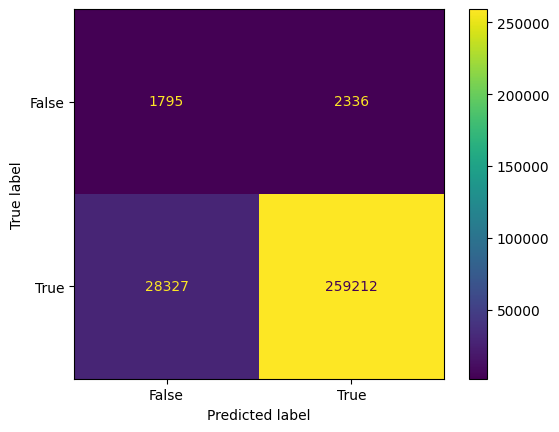

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.867295
Error Rate: 0.13270476908835327
Mean Recall: 0.665707271693065
Balanced Accuracy Score: 0.665707271693065
Precision: 0.520255966941404
F-Score: 0.508766865468486
291670 291670
Selectivity: 0.45824255628177196
G_mean: 0.5523182071197673


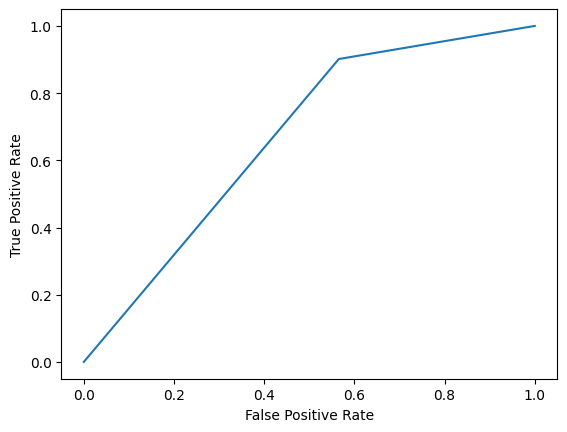

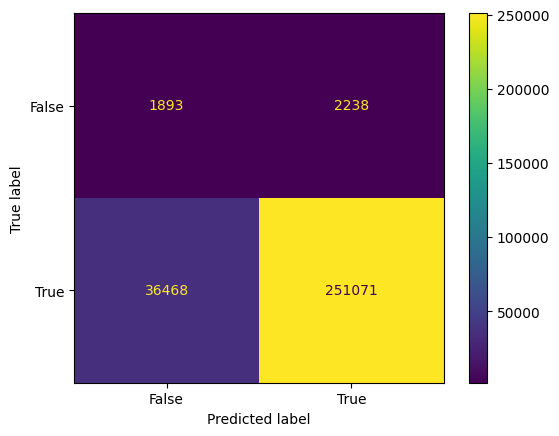

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.886176
Error Rate: 0.11382384201323414
Mean Recall: 0.6498730658753896
Balanced Accuracy Score: 0.6498730658753896
Precision: 0.5211762968797209
F-Score: 0.5155945272431287
291670 291670
Selectivity: 0.4066811909949165
G_mean: 0.5140925523927781


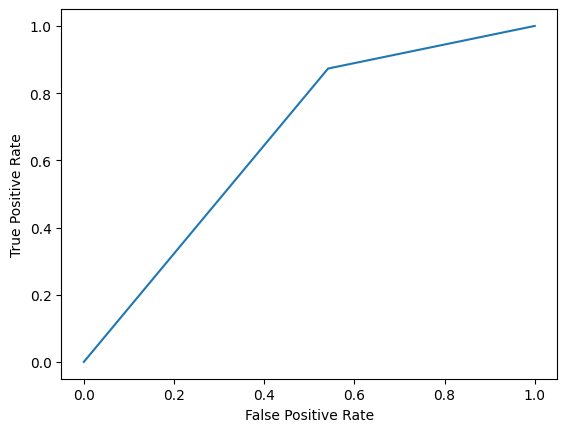

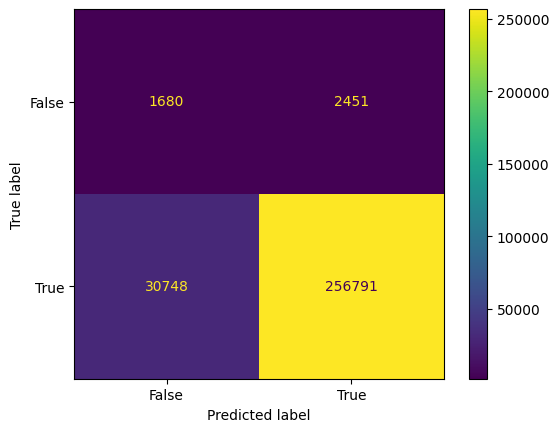

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 0.869603
Error Rate: 0.13039736688723558
Mean Recall: 0.641705843969296
Balanced Accuracy Score: 0.641705843969296
Precision: 0.5177542773063674
F-Score: 0.5055414800160194
291670 291670
Selectivity: 0.40716533526991044
G_mean: 0.5111559205412955


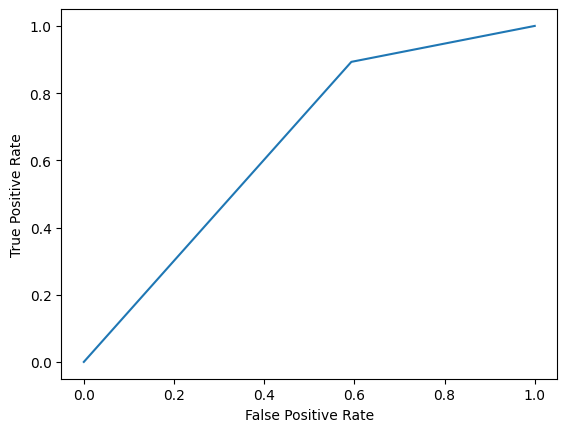

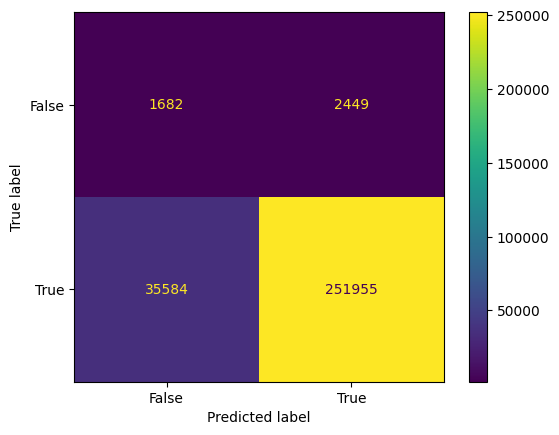

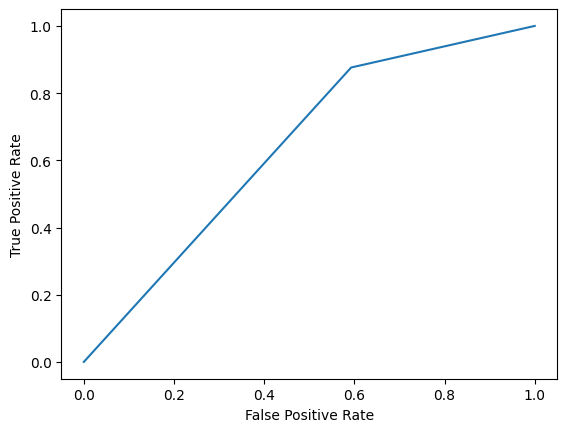

In [17]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)